In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score, recall_score, confusion_matrix, classification_report 
import subprocess
import joblib
# Get multiple outputs in the same cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# Ignore all warnings
import warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

ModuleNotFoundError: No module named 'lightgbm'

In [3]:
dc = pd.read_csv("Churn_Modelling (1).csv")
dc.head(5) 

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
dc.shape

(10000, 14)

In [5]:
dc.describe(exclude= ['O']) 
dc.describe(include = ['O']) 

,Surname,Geography,Gender
count,10000,10000,10000
unique,2932,3,2
top,Smith,France,Male
freq,32,5014,5457


In [6]:

dc.shape[0], dc.CustomerId.nunique()

(10000, 10000)

In [7]:

dc["Exited"].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

In [8]:
dc.groupby(['Surname']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False).head()

,Surname,RowNumber,Exited
2473,Smith,32,0.281250
1689,Martin,29,0.310345
2389,Scott,29,0.103448
2751,Walker,28,0.142857
336,Brown,26,0.192308


In [9]:
dc.groupby(['Geography']).agg({'RowNumber':'count', 'Exited':'mean'}
                                  ).reset_index().sort_values(by='RowNumber', ascending=False)

,Geography,RowNumber,Exited
0,France,5014,0.161548
1,Germany,2509,0.324432
2,Spain,2477,0.166734


<AxesSubplot:ylabel='CreditScore'>

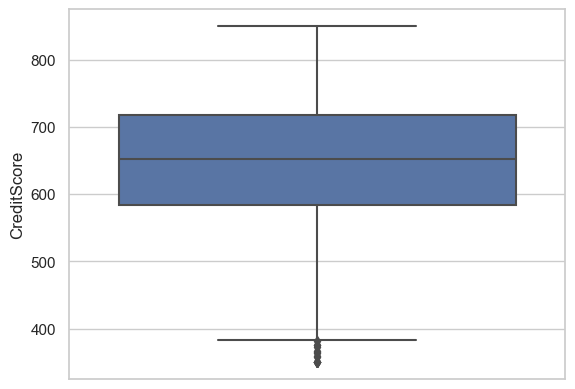

In [10]:
sns.set(style="whitegrid")
sns.boxplot(y=dc['CreditScore'])

<AxesSubplot:ylabel='Age'>

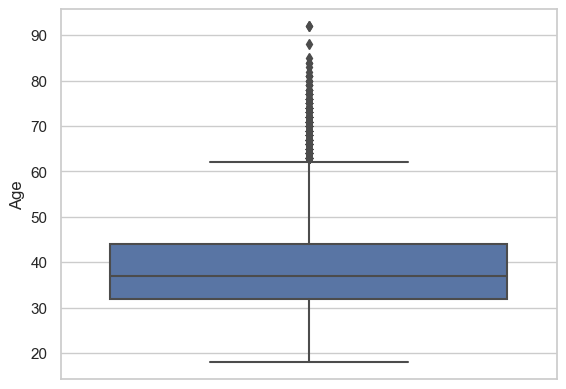

In [11]:
sns.boxplot(y=dc['Age'])

<AxesSubplot:ylabel='Tenure'>

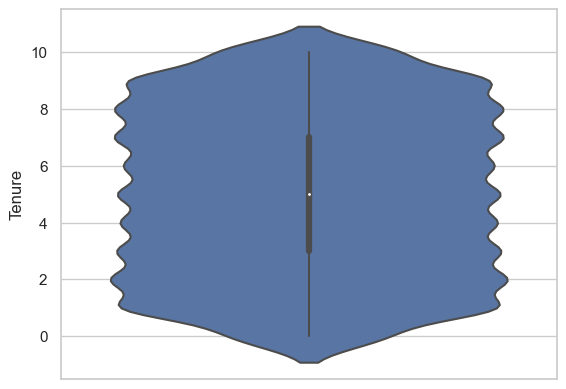

In [12]:
sns.violinplot(y = dc.Tenure)

<AxesSubplot:ylabel='Balance'>

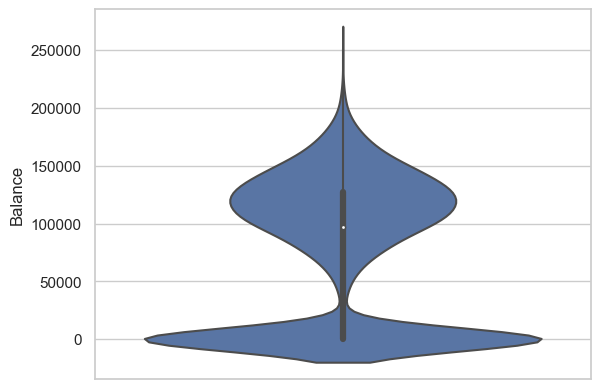

In [13]:
sns.violinplot(y = dc['Balance'])

C:\Users\Victoria\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='NumOfProducts'>

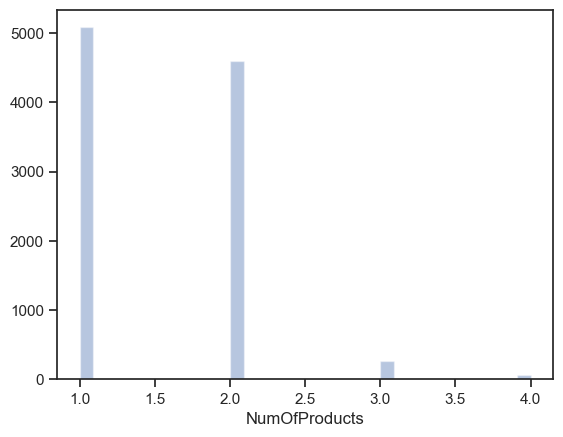

In [14]:
sns.set(style = 'ticks')
sns.distplot(dc.NumOfProducts, hist=True, kde=False)

<AxesSubplot:xlabel='EstimatedSalary', ylabel='Density'>

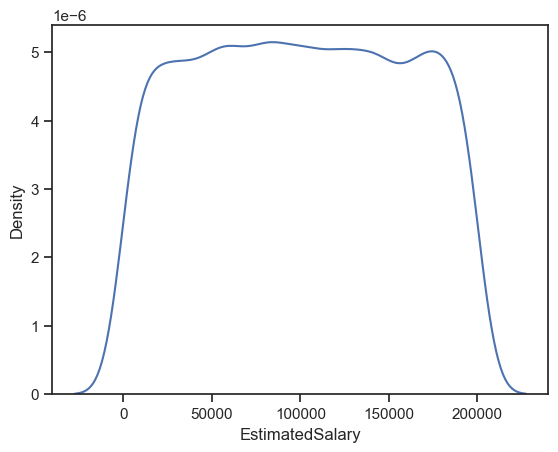

In [15]:
sns.kdeplot(dc.EstimatedSalary)

In [16]:
target_var = ['Exited']
cols_to_remove = ['RowNumber', 'CustomerId']

num_feats = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

cat_feats = ['Surname', 'Geography', 'Gender', 'HasCrCard', 'IsActiveMember']

In [17]:
y = dc[target_var].values
dc.drop(cols_to_remove, axis=1, inplace=True)

In [18]:

dc_train_val, dc_test, y_train_val, y_test = train_test_split(dc, y.ravel(), test_size = 0.1, random_state = 42)


dc_train, dc_val, y_train, y_val = train_test_split(dc_train_val, y_train_val, test_size = 0.12, random_state = 42)
dc_train.shape, dc_val.shape, dc_test.shape, y_train.shape, y_val.shape, y_test.shape
np.mean(y_train), np.mean(y_val), np.mean(y_test)

(0.20303030303030303, 0.22037037037037038, 0.191)

In [19]:
le = LabelEncoder()

dc_train['Gender'] = le.fit_transform(dc_train['Gender'])
le_gender_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_gender_mapping

{'Female': 0, 'Male': 1}

In [20]:
dc_val['Gender'] = dc_val.Gender.map(le_gender_mapping)
dc_test['Gender'] = dc_test.Gender.map(le_gender_mapping)

dc_val['Gender'].fillna(-1, inplace=True)
dc_test['Gender'].fillna(-1, inplace=True)

In [21]:
dc_train.Gender.unique(), dc_val.Gender.unique(), dc_test.Gender.unique()

(array([1, 0]), array([1, 0]), array([1, 0]))

In [22]:
le_ohe = LabelEncoder()
ohe = OneHotEncoder(handle_unknown = 'ignore', sparse=False)
enc_train = le_ohe.fit_transform(dc_train.Geography).reshape(dc_train.shape[0],1)
ohe_train = ohe.fit_transform(enc_train)
ohe_train

array([[0., 1., 0.],
       [1., 0., 0.],
       [1., 0., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [23]:
le_ohe_geography_mapping = dict(zip(le_ohe.classes_, le_ohe.transform(le_ohe.classes_)))
le_ohe_geography_mapping

{'France': 0, 'Germany': 1, 'Spain': 2}

In [24]:

enc_val = dc_val.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)
enc_test = dc_test.Geography.map(le_ohe_geography_mapping).ravel().reshape(-1,1)

enc_val[np.isnan(enc_val)] = 9999
enc_test[np.isnan(enc_test)] = 9999

In [25]:
ohe_val = ohe.transform(enc_val)
ohe_test = ohe.transform(enc_test)

In [26]:
ohe.transform(np.array([[9999]]))

array([[0., 0., 0.]])

In [27]:
cols = ['country_' + str(x) for x in le_ohe_geography_mapping.keys()]
cols

['country_France', 'country_Germany', 'country_Spain']

In [28]:

dc_train = pd.concat([dc_train.reset_index(), pd.DataFrame(ohe_train, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_val = pd.concat([dc_val.reset_index(), pd.DataFrame(ohe_val, columns = cols)], axis = 1).drop(['index'], axis=1)
dc_test = pd.concat([dc_test.reset_index(), pd.DataFrame(ohe_test, columns = cols)], axis = 1).drop(['index'], axis=1)
print("Training set")
dc_train.head()
print("\n\nValidation set")
dc_val.head()
print("\n\nTest set")
dc_test.head()

Training set


Validation set


Test set


,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain
0,Anderson,596,Germany,1,32,3,96709.07,2,0,0,41788.37,0,0.0,1.0,0.0
1,Herring,623,France,1,43,1,0.00,2,1,1,146379.30,0,1.0,0.0,0.0
2,Amechi,601,Spain,0,44,4,0.00,2,1,0,58561.31,0,0.0,0.0,1.0
3,Liang,506,Germany,1,59,8,119152.10,2,1,1,170679.74,0,0.0,1.0,0.0
4,Chuang,560,Spain,0,27,7,124995.98,1,1,1,114669.79,0,0.0,0.0,1.0


In [29]:
dc_train.drop(['Geography'], axis=1, inplace=True)
dc_val.drop(['Geography'], axis=1, inplace=True)
dc_test.drop(['Geography'], axis=1, inplace=True)

In [30]:
means = dc_train.groupby(['Surname']).Exited.mean()
means.head()
means.tail()

Surname
Zubarev     0.0
Zubareva    0.0
Zuev        0.0
Zuyev       0.0
Zuyeva      0.0
Name: Exited, dtype: float64

In [31]:
global_mean = y_train.mean()
global_mean

0.20303030303030303

In [32]:
dc_train['Surname_mean_churn'] = dc_train.Surname.map(means)
dc_train['Surname_mean_churn'].fillna(global_mean, inplace=True)

In [33]:
freqs = dc_train.groupby(['Surname']).size()
freqs.head()

Surname
Abazu       2
Abbie       1
Abbott      4
Abdullah    1
Abdulov     1
dtype: int64

In [34]:
dc_train['Surname_freq'] = dc_train.Surname.map(freqs)
dc_train['Surname_freq'].fillna(0, inplace=True)

In [35]:
dc_train['Surname_enc'] = ((dc_train.Surname_freq * dc_train.Surname_mean_churn) - dc_train.Exited)/(dc_train.Surname_freq - 1)

dc_train['Surname_enc'].fillna((((dc_train.shape[0] * global_mean) - dc_train.Exited) / (dc_train.shape[0] - 1)), inplace=True)
dc_train.head(5)

,Surname,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_mean_churn,Surname_freq,Surname_enc
0,Yermakova,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000,4,0.000000
1,Warlow-Davies,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000,2,0.000000
2,Fu,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.200000,10,0.222222
3,Shih,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.285714,21,0.300000
4,Mahmood,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.333333,3,0.500000


In [36]:

dc_val['Surname_enc'] = dc_val.Surname.map(means)
dc_val['Surname_enc'].fillna(global_mean, inplace=True)
dc_test['Surname_enc'] = dc_test.Surname.map(means)
dc_test['Surname_enc'].fillna(global_mean, inplace=True)

dc_train[['Surname_mean_churn', 'Surname_enc', 'Exited']].corr()

,Surname_mean_churn,Surname_enc,Exited
Surname_mean_churn,1.000000,0.54823,0.562677
Surname_enc,0.548230,1.00000,-0.026440
Exited,0.562677,-0.02644,1.000000


In [37]:
dc_train.drop(['Surname_mean_churn'], axis=1, inplace=True)
dc_train.drop(['Surname_freq'], axis=1, inplace=True)
dc_train.drop(['Surname'], axis=1, inplace=True)
dc_val.drop(['Surname'], axis=1, inplace=True)
dc_test.drop(['Surname'], axis=1, inplace=True)
dc_train.head()

,CreditScore,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,country_France,country_Germany,country_Spain,Surname_enc
0,678,1,36,1,117864.85,2,1,0,27619.06,0,0.0,1.0,0.0,0.000000
1,613,0,27,5,125167.74,1,1,0,199104.52,0,1.0,0.0,0.0,0.000000
2,628,1,45,9,0.00,2,1,1,96862.56,0,1.0,0.0,0.0,0.222222
3,513,1,30,5,0.00,2,1,0,162523.66,0,1.0,0.0,0.0,0.300000
4,639,1,22,4,0.00,2,1,0,28188.96,0,1.0,0.0,0.0,0.500000


In [38]:
corr = dc_train.corr()

<AxesSubplot:>

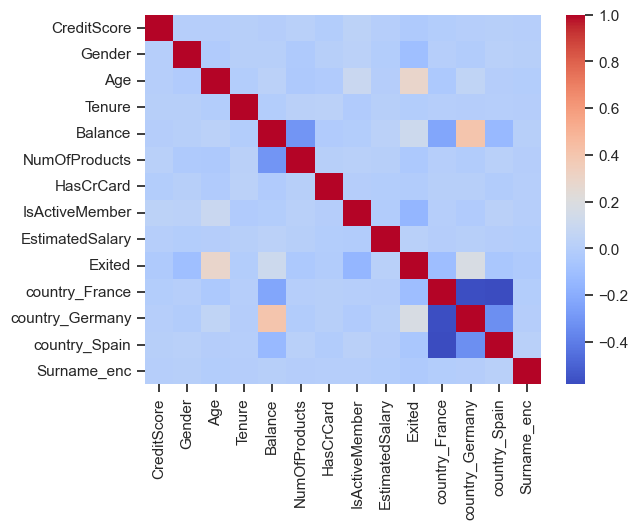

In [39]:
sns.heatmap(corr, cmap = 'coolwarm')

<AxesSubplot:xlabel='Exited', ylabel='Age'>

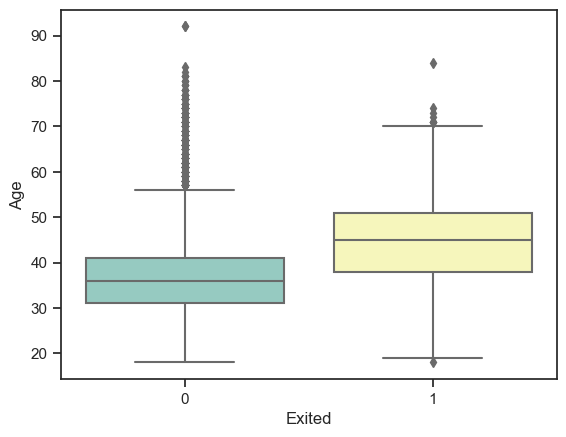

In [40]:
sns.boxplot(x="Exited", y="Age", data=dc_train, palette="Set3")

<AxesSubplot:xlabel='Exited', ylabel='Balance'>

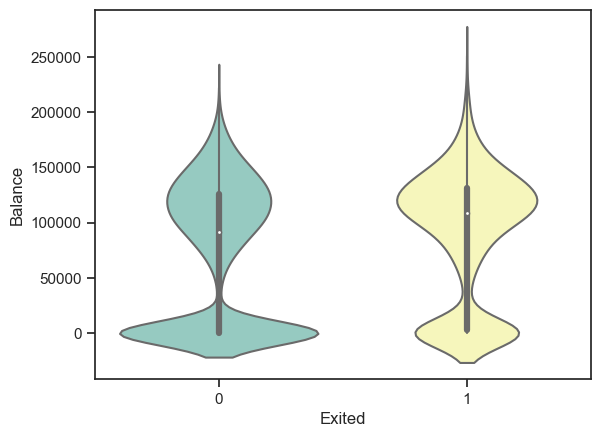

In [41]:
sns.violinplot(x="Exited", y="Balance", data=dc_train, palette="Set3")

In [42]:
cat_vars_bv = ['Gender', 'IsActiveMember', 'country_Germany', 'country_France']

for col in cat_vars_bv:
    dc_train.groupby([col]).Exited.mean()
    print()

In [43]:

col = 'NumOfProducts'
dc_train.groupby([col]).Exited.mean()

dc_train[col].value_counts()

1    4023
2    3629
3     223
4      45
Name: NumOfProducts, dtype: int64

In [44]:
eps = 1e-6

dc_train['bal_per_product'] = dc_train.Balance/(dc_train.NumOfProducts + eps)
dc_train['bal_by_est_salary'] = dc_train.Balance/(dc_train.EstimatedSalary + eps)
dc_train['tenure_age_ratio'] = dc_train.Tenure/(dc_train.Age + eps)
dc_train['age_surname_mean_churn'] = np.sqrt(dc_train.Age) * dc_train.Surname_enc

In [45]:
new_cols = ['bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']

dc_train[new_cols].isnull().sum()

bal_per_product           0
bal_by_est_salary         0
tenure_age_ratio          0
age_surname_mean_churn    0
dtype: int64

<AxesSubplot:>

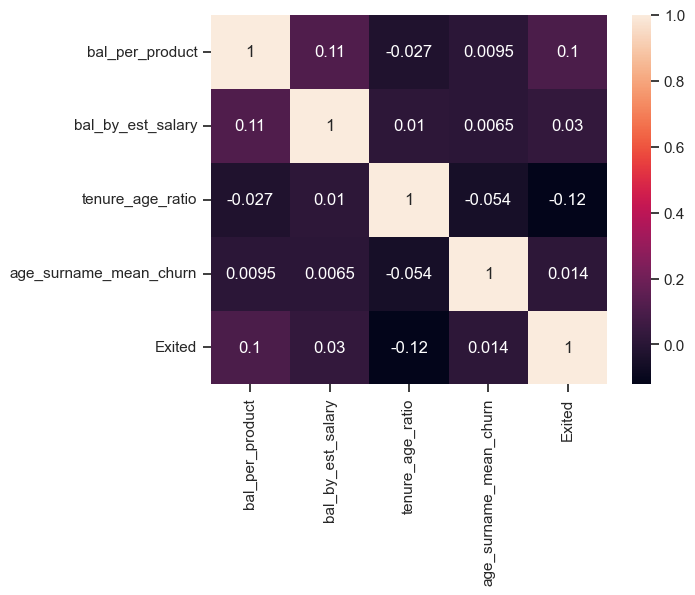

In [46]:

sns.heatmap(dc_train[new_cols + ['Exited']].corr(), annot=True)

In [47]:
dc_val['bal_per_product'] = dc_val.Balance/(dc_val.NumOfProducts + eps)
dc_val['bal_by_est_salary'] = dc_val.Balance/(dc_val.EstimatedSalary + eps)
dc_val['tenure_age_ratio'] = dc_val.Tenure/(dc_val.Age + eps)
dc_val['age_surname_mean_churn'] = np.sqrt(dc_val.Age) * dc_val.Surname_enc
dc_test['bal_per_product'] = dc_test.Balance/(dc_test.NumOfProducts + eps)
dc_test['bal_by_est_salary'] = dc_test.Balance/(dc_test.EstimatedSalary + eps)
dc_test['tenure_age_ratio'] = dc_test.Tenure/(dc_test.Age + eps)
dc_test['age_surname_mean_churn'] = np.sqrt(dc_test.Age) * dc_test.Surname_enc

In [48]:
sc = StandardScaler()
cont_vars = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc', 'bal_per_product'
             , 'bal_by_est_salary', 'tenure_age_ratio', 'age_surname_mean_churn']
cat_vars = ['Gender', 'HasCrCard', 'IsActiveMember', 'country_France', 'country_Germany', 'country_Spain']

cols_to_scale = cont_vars
sc_X_train = sc.fit_transform(dc_train[cols_to_scale])

sc_X_train = pd.DataFrame(data=sc_X_train, columns=cols_to_scale)
sc_X_train.shape
sc_X_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,EstimatedSalary,Surname_enc,bal_per_product,bal_by_est_salary,tenure_age_ratio,age_surname_mean_churn
0,0.284761,-0.274383,-1.389130,0.670778,0.804059,-1.254732,-1.079210,-0.062389,0.095448,-1.232035,-1.062507
1,-0.389351,-1.128482,-0.004763,0.787860,-0.912423,1.731950,-1.079210,1.104840,-0.118834,0.525547,-1.062507
2,-0.233786,0.579716,1.379604,-1.218873,0.804059,-0.048751,0.094549,-1.100925,-0.155854,0.690966,0.193191
3,-1.426446,-0.843782,-0.004763,-1.218873,0.804059,1.094838,0.505364,-1.100925,-0.155854,0.318773,0.321611
4,-0.119706,-1.602981,-0.350855,-1.218873,0.804059,-1.244806,1.561746,-1.100925,-0.155854,0.487952,0.912973


In [49]:

sc_X_val = sc.transform(dc_val[cols_to_scale])
sc_X_test = sc.transform(dc_test[cols_to_scale])

sc_X_val = pd.DataFrame(data=sc_X_val, columns=cols_to_scale)
sc_X_test = pd.DataFrame(data=sc_X_test, columns=cols_to_scale)

In [50]:

y = dc_train['Exited'].values
X = dc_train[cat_vars + cont_vars]
X.columns = cat_vars + cont_vars
X.columns

Index(['Gender', 'HasCrCard', 'IsActiveMember', 'country_France',
       'country_Germany', 'country_Spain', 'CreditScore', 'Age', 'Tenure',
       'Balance', 'NumOfProducts', 'EstimatedSalary', 'Surname_enc',
       'bal_per_product', 'bal_by_est_salary', 'tenure_age_ratio',
       'age_surname_mean_churn'],
      dtype='object')

In [52]:
rfe = RFE(estimator=LogisticRegression(), n_features_to_select=10) 
rfe = rfe.fit(X.values, y) 

print(rfe.support_)

print(rfe.ranking_)

C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

[ True  True  True  True  True  True False  True False False  True False
  True False False  True False]
[1 1 1 1 1 1 4 1 3 6 1 8 1 7 5 1 2]


C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\Victoria\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n

In [53]:

mask = rfe.support_.tolist()
selected_feats = [b for a,b in zip(mask, X.columns) if a]
selected_feats

['Gender',
 'HasCrCard',
 'IsActiveMember',
 'country_France',
 'country_Germany',
 'country_Spain',
 'Age',
 'NumOfProducts',
 'Surname_enc',
 'tenure_age_ratio']

In [54]:
rfe_dt = RFE(estimator=DecisionTreeClassifier(max_depth = 4, criterion = 'entropy'), n_features_to_select=10) 
rfe_dt = rfe_dt.fit(X.values, y)  

In [55]:
mask = rfe_dt.support_.tolist()
selected_feats_dt = [b for a,b in zip(mask, X.columns) if a]
selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [56]:
selected_cat_vars = [x for x in selected_feats if x in cat_vars]
selected_cont_vars = [x for x in selected_feats if x in cont_vars]

X_train = np.concatenate((dc_train[selected_cat_vars].values, sc_X_train[selected_cont_vars].values), axis=1)
X_val = np.concatenate((dc_val[selected_cat_vars].values, sc_X_val[selected_cont_vars].values), axis=1)
X_test = np.concatenate((dc_test[selected_cat_vars].values, sc_X_test[selected_cont_vars].values), axis=1)

X_train.shape, X_val.shape, X_test.shape

((7920, 10), (1080, 10), (1000, 10))

In [57]:

_, num_samples = np.unique(y_train, return_counts=True)
weights = np.max(num_samples)/num_samples

weights_dict = dict()
class_labels = [0,1]

for a,b in zip(class_labels,weights):
    weights_dict[a] = b

weights_dict

{0: 1.0, 1: 3.925373134328358}

In [58]:

lr = LogisticRegression(C=1.0, penalty='l2', class_weight=weights_dict, n_jobs=-1)

lr.fit(X_train, y_train)
print(f'Confusion Matrix: \n{confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

NameError: name 'confusion_matrix' is not defined

In [59]:
svm = SVC(C=1.0, kernel="linear", class_weight=weights_dict)
svm.fit(X_train, y_train)

SVC(class_weight={0: 1.0, 1: 3.925373134328358}, kernel='linear')

In [60]:

print(f'Confusion Matrix: {confusion_matrix(y_val, lr.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, lr.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,lr.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,lr.predict(X_val))}')

NameError: name 'confusion_matrix' is not defined

In [61]:
pca = PCA(n_components=2)

X_pca = pca.fit_transform(X_train)
y = y_train
X_pca.shape, y.shape

((7920, 2), (7920,))

C:\Users\Victoria\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, 'Linear models - LogReg and SVM')

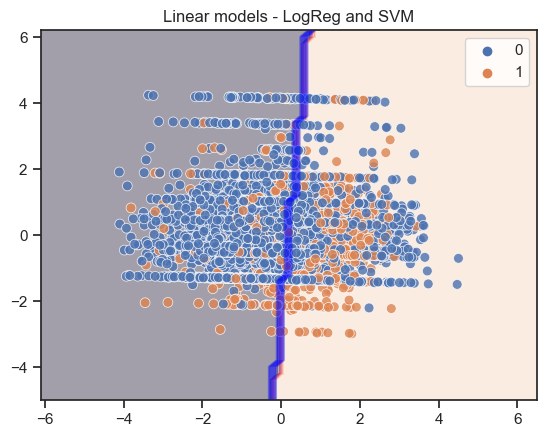

In [62]:

xmin, xmax = X_pca[:, 0].min() - 2, X_pca[:, 0].max() + 2
ymin, ymax = X_pca[:, 1].min() - 2, X_pca[:, 1].max() + 2

xx, yy = np.meshgrid(np.arange(xmin, xmax, 0.2),
                     np.arange(ymin, ymax, 0.2))

lr.fit(X_pca, y)

svm.fit(X_pca, y)

z1 = lr.predict(np.c_[xx.ravel(), yy.ravel()])
z1 = z1.reshape(xx.shape)

z2 = svm.predict(np.c_[xx.ravel(), yy.ravel()])
z2 = z2.reshape(xx.shape)

plt.contourf(xx, yy, z1, alpha=0.4) # LR
plt.contour(xx, yy, z2, alpha=0.4, colors='blue') # SVM
sns.scatterplot(X_pca[:,0], X_pca[:,1], hue=y_train, s=50, alpha=0.8)
plt.title('Linear models - LogReg and SVM')

In [63]:

selected_feats_dt

['IsActiveMember',
 'country_Germany',
 'Age',
 'Balance',
 'NumOfProducts',
 'EstimatedSalary',
 'bal_per_product',
 'bal_by_est_salary',
 'tenure_age_ratio',
 'age_surname_mean_churn']

In [64]:

X_train = dc_train[selected_feats_dt].values
X_val = dc_val[selected_feats_dt].values

clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, max_depth=4, max_features=None
                            , min_samples_split=25, min_samples_leaf=15)

clf.fit(X_train, y_train)

pd.DataFrame({'features': selected_feats,
              'importance': clf.feature_importances_
             }).sort_values(by='importance', ascending=False)

,features,importance
2,IsActiveMember,0.476841
4,country_Germany,0.351863
0,Gender,0.096402
6,Age,0.032268
1,HasCrCard,0.028361
7,NumOfProducts,0.010400
5,country_Spain,0.003865
3,country_France,0.000000
8,Surname_enc,0.000000
9,tenure_age_ratio,0.000000


In [65]:

print(f'Confusion Matrix: {confusion_matrix(y_val, clf.predict(X_val))}')
print(f'Area Under Curve: {roc_auc_score(y_val, clf.predict(X_val))}')
print(f'Recall score: {recall_score(y_val,clf.predict(X_val))}')
print(f'Classification report: \n{classification_report(y_val,clf.predict(X_val))}')

NameError: name 'confusion_matrix' is not defined

In [66]:

clf = DecisionTreeClassifier(criterion='entropy', class_weight=weights_dict, 
                            max_depth=3, max_features=None,
                            min_samples_split=25, min_samples_leaf=15)

clf.fit(X_train, y_train)

dot_data = export_graphviz(clf, out_file='tree.dot',
                          feature_names=selected_feats_dt,
                          class_names=['Did not churn', 'Churned'],
                          rounded=True, proportion=False,
                          precision=2, filled=True)

subprocess.run(['dot', '-Tpng','tree.dot', '-o', 'tree.png', '-Gdpi=600'])

from IPython.display import Image
Image(filename='tree.png')

NameError: name 'subprocess' is not defined

In [67]:
from utils import *



X_train = dc_train.drop(columns = ['Exited'], axis=1)
X_val = dc_val.drop(columns = ['Exited'], axis=1)

best_f1_lgb = LGBMClassifier(boosting_type='dart', class_weight={0: 1, 1: 3.0}, min_child_samples=20, n_jobs=-1, importance_type='gain', max_depth=6, num_leaves=63, colsample_bytree=0.6, learning_rate=0.1, n_estimators=201, reg_alpha=1, reg_lambda=1)
best_recall_lgb = LGBMClassifier(boosting_type='dart', num_leaves=31, max_depth=6, learning_rate=0.1, n_estimators=21, class_weight={0: 1, 1: 3.93}, min_child_samples=2, colsample_bytree=0.6, reg_alpha=0.3, reg_lambda=1.0, n_jobs=-1, importance_type='gain')
model = Pipeline(steps = [('categorical_encoding', CategoricalEncoder()),
                          ('add_new_features', AddFeatures()),
                          ('classifier', best_f1_lgb)
                         ])

model.fit(X_train, y_train)

val_probs = model.predict_proba(X_val)[:,1]

val_preds = np.where(val_probs > 0.45, 1, 0) 

print(f'Confusion Matrix: {confusion_matrix(y_val,val_preds)}')
print(f'Area Under Curve: {roc_auc_score(y_val,val_preds)}')
print(f'Recall score: {recall_score(y_val,val_preds)}')
print(f'Classification report: \n{classification_report(y_val,val_preds)}')

ModuleNotFoundError: No module named 'utils'

In [68]:

model = joblib.load('final_churn_model_f1_0_45.sav')
X_test = dc_test.drop(columns=['Exited'], axis=1
                      
test_probs = model.predict_proba(X_test)[:,1]

test_preds = np.where(test_probs > 0.45, 1, 0) 
                      
roc_auc_score(y_test, test_preds)
recall_score(y_test, test_preds)
confusion_matrix(y_test, test_preds)
print(classification_report(y_test, test_preds))

SyntaxError: invalid syntax (431147763.py, line 4)

In [69]:

test = dc_test.copy()
test['predictions'] = test_preds
test['pred_probabilities'] = test_probs
test.sample(5)

NameError: name 'test_preds' is not defined

In [70]:
high_churn_list = test[test.pred_probabilities > 0.7].sort_values(by=['pred_probabilities'], ascending=False
                                                                 ).reset_index().drop(columns=['index', 'Exited', 'predictions'], axis=1)
high_churn_list.shape
high_churn_list.head()

AttributeError: 'DataFrame' object has no attribute 'pred_probabilities'

In [72]:
high_churn_list.to_csv('Churn_Modelling (1).csv', index=False)

NameError: name 'high_churn_list' is not defined